# Execução do notebook de pre-processamento

Essa execução irá carregar aqui todas as importações e variaveis de ambiente criadas no notebook **preprocessing.ipynb**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

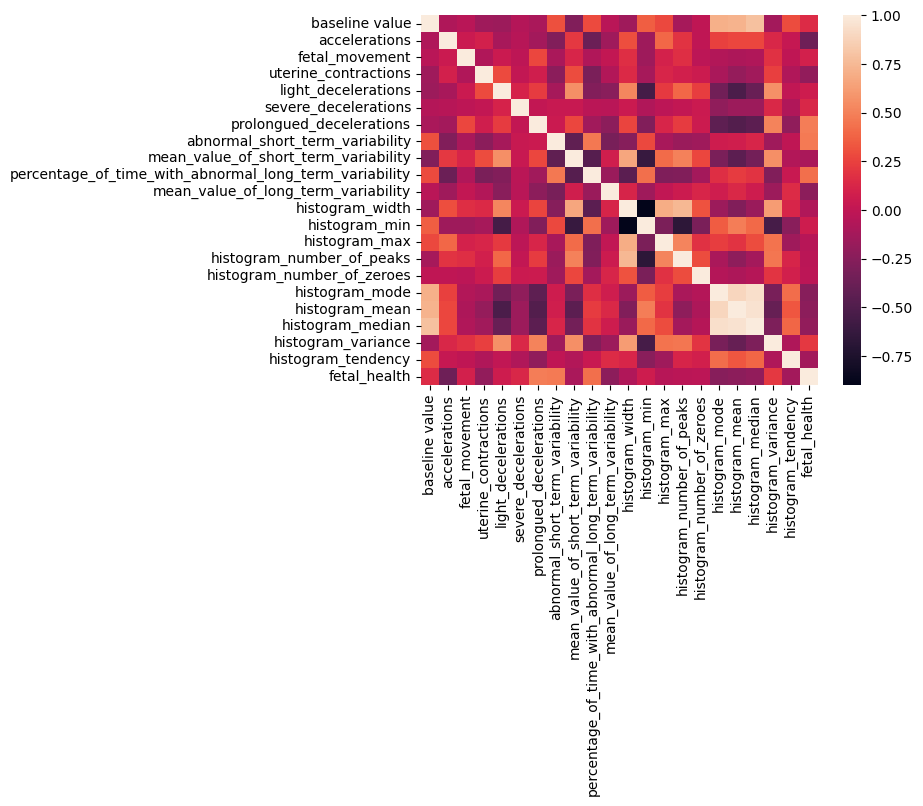

In [1]:
%run preprocessing.ipynb

### Legenda:

1 - Normal

2 - Suspeito / Patologico (positivo)

# KNN

## Quantidade do alvo fetal_health

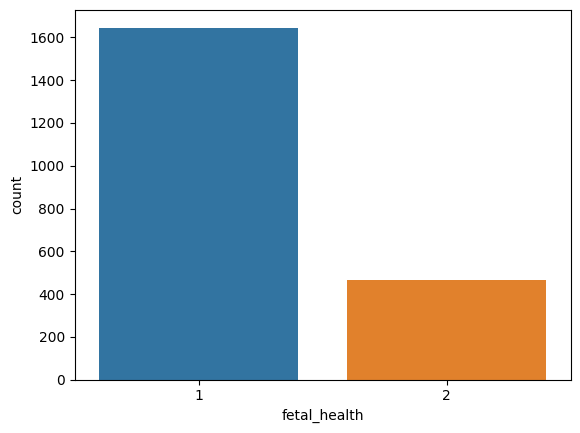

In [2]:
sns.countplot(data=fetal_health, x="fetal_health")
plt.show()

In [3]:
fetal_health.fetal_health.value_counts(normalize=True)

1    0.778987
2    0.221013
Name: fetal_health, dtype: float64

#### Observação importante: Os dados estão bem desbalanceados, mas tendo em vista que o desbalanciamento é exatamente o replexo do cenário atual, onde temos mais fetos normais que suspeitos ou patologico

## Pipeline

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

steps = [
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier()),
]

pipe = Pipeline(steps)

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, recall_score

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
score = make_scorer(recall_score, pos_label=2)

## Treinamento com Grid Search CV

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "knn__n_neighbors": range(5, 21),
    "knn__weights": ["uniform", "distance"],
    "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=splitter,
    scoring=score,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__n_neighbors': range(5, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, pos_label=2))

## Melhores parâmetros

In [7]:
grid.best_estimator_, grid.best_params_

(Pipeline(steps=[('ss', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=6, weights='distance'))]),
 {'knn__algorithm': 'auto', 'knn__n_neighbors': 6, 'knn__weights': 'distance'})

## Predição da base de treino

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1316
           2       1.00      0.99      1.00       374

    accuracy                           1.00      1690
   macro avg       1.00      1.00      1.00      1690
weighted avg       1.00      1.00      1.00      1690



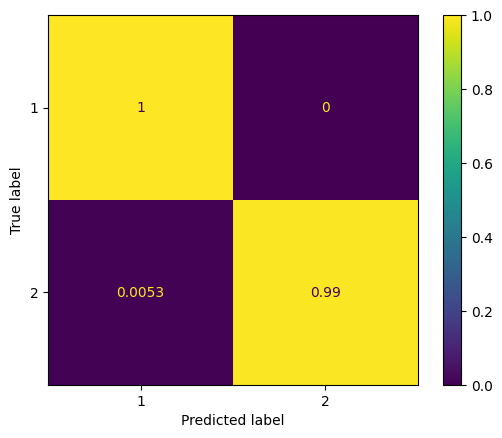

In [8]:
print_report(grid, X_train, y_train, normalize="true")

## Predição da base de teste

              precision    recall  f1-score   support

           1       0.95      0.98      0.96       330
           2       0.90      0.82      0.86        93

    accuracy                           0.94       423
   macro avg       0.93      0.90      0.91       423
weighted avg       0.94      0.94      0.94       423



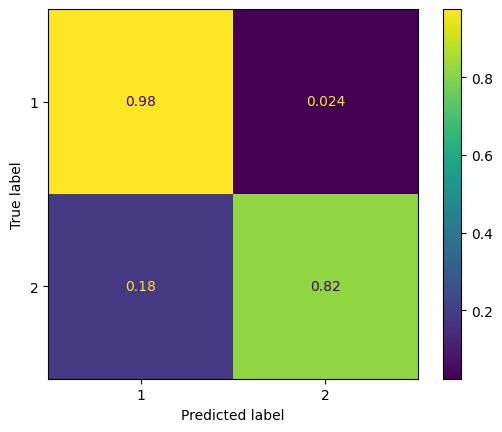

In [9]:
print_report(grid, X_test, y_test, normalize="true")

Em resumo, o modelo sofre de overfitting pois se adaptou muito bem aos dados com os quais está sendo treinado; porém, não generaliza bem para novos dados. Ou seja, o modelo “decorou” o conjunto de dados de treino, mas não aprendeu de fato o que diferencia aqueles dados para quando precisar enfrentar novos testes. Mesmo alterando o range, as metricas e o scaller não temos resolução pra isso. 

#### Não atendeu.